# Index

0. [Motivation and objective of the project](#0.-Motivation-and-objective-of-the-project)
1. [Data loading and preliminary analysis](#1.-Data-loading-and-preliminary-analysis)
2. [Analysis of target distribution and data preparation](#2.-Analysis-of-target-distribution-and-data-preparation)
3. [Modeling and evaluation](#3.-Modeling-and-evaluation)

    3.1. [Binary classification](#3.1.-Binary-classification) 
    
    3.2. [Multiclass classification](#3.2.-Multiclass-classification)

4. [Conclusions](#4.-Conclusions)

# 0. Motivation and objective of the project

Defects in the manufacturing of food cans can have a significant impact on product quality. At best, the damage caused affects the brand's image; at worst, it becomes a food safety issue. On the other hand, the importance of defect control entails manual inspection processes that increase production costs and also cause delays in intermediate manufacturing processes

Some of the potential problems that defects in food cans could cause:

1. **Product Contamination**: A defective can could allow contaminants such as oxygen or microorganisms to come into contact with the canned food, potentially causing spoilage or contamination of the product.

2. **Loss of Freshness and Product Quality**: The presence of a defective can may compromise the integrity of the seal and cause the canned food to lose its freshness and original quality more rapidly than expected.

3. **Alteration of Taste and Aroma**: Exposure of the canned food to external agents due to a defective can may alter its taste and aroma, resulting in a negative sensory experience for consumers.

4. **Nutritional Degradation**: If the canned product is not adequately sealed due to a defective can, there's a possibility that the food's nutrients may degrade more rapidly, negatively affecting its nutritional value.

5. **Loss of Consumer Trust**: The presence of canned products with defective cans could create distrust among consumers regarding the quality and safety of the brand, potentially leading to decreased sales and damaging the company's reputation.

6. **Market Withdrawal**: If it's discovered that a batch of canned products has defective cans, it may be necessary to withdraw the product from the market, incurring additional costs for the company and potentially impacting its public image.

The objective of this project is to use a Convolutional Neural Network to analyze images of cans (which have been automatically obtained at certain stages of the production line), so that by applying a combined strategy of automated inspection and manual inspection (the latter at critical stages), product quality is ensured, and production costs and times are reduced

**Why a Deep Learning model?**

1. Deep learning models can learn to distinguish between different types of patterns

2. Is a powerful tool that can be used to improve the efficiency and reliability by identifying and localizing defects early on

3. Deep learning models can achieve high accuracy in detecting defects, even in cases where human inspectors may miss them

4. Deep learning models can quickly scan large amounts of data to identify potential defects

5. Deep learning models can be used to automate the defect detection process, which can save money on labor costs

# 1. Data loading and preliminary analysis

In [1]:
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns

from skimage.io import imread
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, recall_score, f1_score, precision_score
from sklearn.utils import shuffle, class_weight
from time import time

In [2]:
ROOT_PATH_TRAIN = "./data/can_defects/train"
ROOT_PATH_VALID = "./data/can_defects/valid"
ROOT_PATH_TEST = "./data/can_defects/test"

We define the dimensions of the images to work with them

In [3]:
img_width = 128
img_height = 128

We read the images and create the X and y for each set

In [4]:
def read_data(path, reshape_dim, list_file_name = False):
    
    X = [] 
    y = []
    file_names = []

    for folder in os.listdir(path):
        
        print("Reading files from folder:", folder)
                
        if os.path.isdir('/'.join([path, folder])):

            for file in os.listdir('/'.join([path, folder])):
        
                image = imread('/'.join([path, folder, file]))
                image = image[:, :, :3] # To remove the alpha channel, if applicable
                image = cv2.resize(image, reshape_dim)

                X.append(image)
                y.append(folder)
                
                if list_file_name:
                    
                    file_names.append(file[:-4])
                                        
    if list_file_name:

        return np.array(X), np.array(y), np.array(file_names)
    
    else:
    
        return np.array(X), np.array(y)

In [5]:
X_train, y_train_label = read_data(path=ROOT_PATH_TRAIN, reshape_dim=(img_width, img_height))

Reading files from folder: critical_defect
Reading files from folder: major_defect
Reading files from folder: minor_defect
Reading files from folder: no_defect


In [6]:
print("X_train shape:", X_train.shape)
print("y_train_label shape:", y_train_label.shape)

X_train shape: (5658, 128, 128, 3)
y_train_label shape: (5658,)


In [7]:
X_valid, y_valid_label = read_data(path=ROOT_PATH_VALID, reshape_dim=(img_width, img_height))

Reading files from folder: critical_defect
Reading files from folder: major_defect
Reading files from folder: minor_defect
Reading files from folder: no_defect


In [8]:
print("X_valid shape:", X_valid.shape)
print("y_valid_label shape:", y_valid_label.shape)

X_valid shape: (1609, 128, 128, 3)
y_valid_label shape: (1609,)


In [9]:
X_test, y_test_label, names = read_data(ROOT_PATH_TEST, reshape_dim=(img_width, img_height), list_file_name=True)

Reading files from folder: critical_defect
Reading files from folder: major_defect
Reading files from folder: minor_defect
Reading files from folder: no_defect


In [10]:
print("X_test shape:", X_test.shape)
print("y_test_label shape:", y_test_label.shape)
print("names shape:", names.shape)

X_test shape: (828, 128, 128, 3)
y_test_label shape: (828,)
names shape: (828,)


We display some images with their associated class

In [11]:
def show_images_batch(images, classes = [], n_cols = 5, size_scale = 2):
    
    n_rows = ((len(images) - 1) // n_cols + 1)
    
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    
    for index, image in enumerate(images):
        
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")
        
        if len(classes):
            
            plt.title(classes[index])

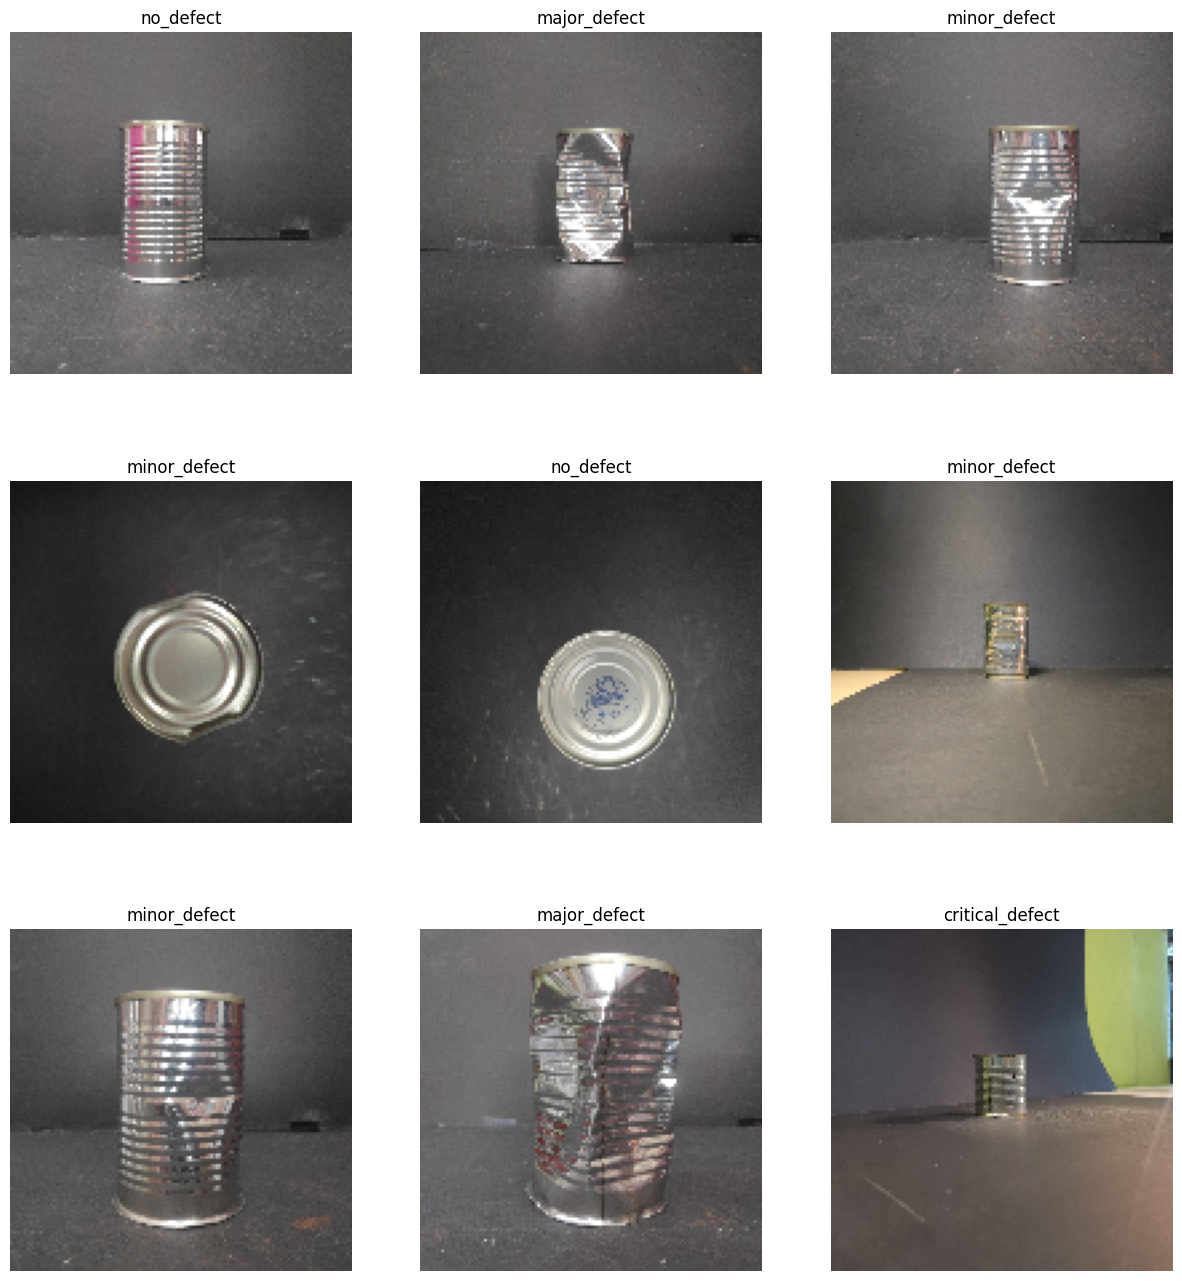

In [13]:
index = np.random.randint(0, len(X_train), 9)
show_images_batch(images = X_train[index], classes = y_train_label[index], n_cols = 3, size_scale = 5)

# 2. Analysis of target distribution and data preparation

We start by evaluating the distribution of each class to choose the appropriate metric

In [14]:
target = pd.Series(y_train_label)
target.value_counts(normalize=True)

minor_defect       0.270414
critical_defect    0.248498
no_defect          0.241075
major_defect       0.240014
Name: proportion, dtype: float64

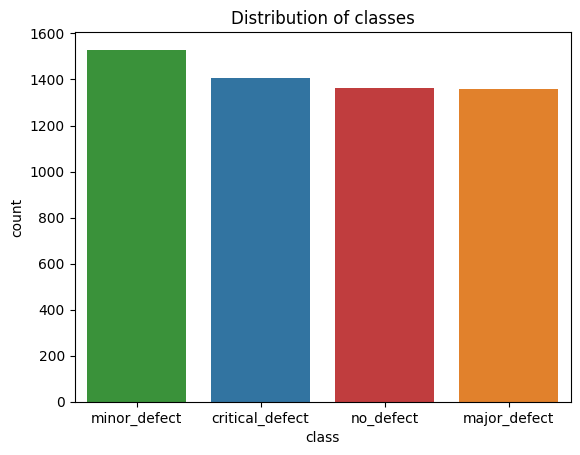

In [15]:
df_target = pd.DataFrame(y_train_label, columns=["class"])
sns.countplot(data=df_target, x="class", order=df_target["class"].value_counts().index, hue=df_target["class"])
plt.title("Distribution of classes");

We have a fairly balanced dataset, although the class "minor_defect" is slightly more prevalent compared to the others. Accuracy will be a good metric to evaluate the model's performance

The first step we will take is a simpler classification based on whether the can is defective or not

In [16]:
y_train_label_binary = [label if label == "no_defect" else "defect" for label in y_train_label]
y_valid_label_binary = [label if label == "no_defect" else "defect" for label in y_valid_label]
y_test_label_binary = [label if label == "no_defect" else "defect" for label in y_test_label]

In [17]:
target_binary = pd.Series(y_train_label_binary)
target_binary.value_counts(normalize=True)

defect       0.758925
no_defect    0.241075
Name: proportion, dtype: float64

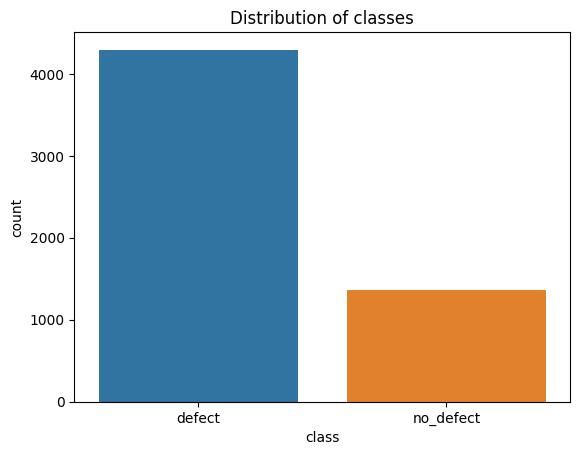

In [18]:
df_target_binary = pd.DataFrame(y_train_label_binary, columns=["class"])
sns.countplot(data=df_target_binary, x="class", order=df_target_binary["class"].value_counts().index, hue=df_target_binary["class"])
plt.title("Distribution of classes");

For this binary grouping, we have an imbalanced dataset. We will use class balancing during training to improve the model's performance

Since we have read the images in order according to each class, we will shuffle the data to prevent the model from learning the order of the data

In [19]:
X_train_s, y_train_label_s = shuffle(X_train, y_train_label, random_state = 42)
X_train_s, y_train_label_binary_s = shuffle(X_train, y_train_label_binary, random_state = 42)

The next step will be to map the classes to convert them into numerical values

In [20]:
# Binary classification
categories_binary = np.unique(y_train_label_binary_s)
n_categories_binary = len(categories_binary)

mapping_binary = {cat: i for i, cat in enumerate(categories_binary)}
inverse_mapping_binary = {valor:clave for clave,valor in mapping_binary.items()}

# Multi classification
categories = np.unique(y_train_label_s)
n_categories = len(categories)

mapping = {cat: i for i, cat in enumerate(categories)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}


In [21]:
print("Mapping binary:", mapping_binary)
print("Inverse mapping binary:", inverse_mapping_binary)

print("Mapping multi:", mapping)
print("Inverse mapping multi:", inverse_mapping)

Mapping binary: {'defect': 0, 'no_defect': 1}
Inverse mapping binary: {0: 'defect', 1: 'no_defect'}
Mapping multi: {'critical_defect': 0, 'major_defect': 1, 'minor_defect': 2, 'no_defect': 3}
Inverse mapping multi: {0: 'critical_defect', 1: 'major_defect', 2: 'minor_defect', 3: 'no_defect'}


In [22]:
# Train set
y_train_num_binary_s = np.array([mapping_binary[cat] for cat in y_train_label_binary_s])
y_train_num_s = np.array([mapping[cat] for cat in y_train_label_s])

# Validation set
y_valid_num_binary = np.array([mapping_binary[cat] for cat in y_valid_label_binary])
y_valid_num = np.array([mapping[cat] for cat in y_valid_label])

# Test set
y_test_num_binary = np.array([mapping_binary[cat] for cat in y_test_label_binary])
y_test_num = np.array([mapping[cat] for cat in y_test_label])

Finally, we will scale the data to a range of values between 0 and 1

In [23]:
X_train_s = X_train_s/255
X_valid = X_valid/255
X_test = X_test/255

# 3. Modeling and evaluation

## 3.1. Binary classification 

First, we will create the model for binary classification

In [43]:
# Create model
binary_model = keras.Sequential()

#First convolutional layer and pooling
binary_model.add(keras.layers.Conv2D(filters = 8, kernel_size = (5, 5), strides = (2,2), input_shape = X_train[0].shape, padding = "same", activation = 'relu'))
binary_model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))

# Dropout layer
binary_model.add(keras.layers.Dropout(0.5))

# Second convolutional layer and pooling
binary_model.add(keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = (2,2), padding = "same", activation = 'relu'))
binary_model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))

# Dropout layer
binary_model.add(keras.layers.Dropout(0.5))

# Flatten layer to convert the output from the pooling layer into a vector
binary_model.add(keras.layers.Flatten())

# First hidden dense layer
binary_model.add(keras.layers.Dense(units = 1024, activation = 'relu'))

# Dropout layer
binary_model.add(keras.layers.Dropout(0.5))

# Output layer
binary_model.add(keras.layers.Dense(units = 1, activation='sigmoid'))

# Compiler
binary_model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['acc'])

In [44]:
binary_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,052,401 (4.01 MB)

 Trainable params: 1,052,401 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

We define the early stopping by monitoring validation accuracy

In [47]:
early_stop_binary = keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 10, restore_best_weights = True)

We choose the batch size aiming for 100 steps per epoch

In [48]:
instancies_train = len(X_train_s)

for i in range(1,10):
    print(f"Batch_size: {8*i}, num_steps_per_epoch: {round(instancies_train/(8*i))}")

Batch_size: 8, num_steps_per_epoch: 707
Batch_size: 16, num_steps_per_epoch: 354
Batch_size: 24, num_steps_per_epoch: 236
Batch_size: 32, num_steps_per_epoch: 177
Batch_size: 40, num_steps_per_epoch: 141
Batch_size: 48, num_steps_per_epoch: 118
Batch_size: 56, num_steps_per_epoch: 101
Batch_size: 64, num_steps_per_epoch: 88
Batch_size: 72, num_steps_per_epoch: 79


In [49]:
batch_size = 56

We calculate the weights for class imbalance and train the model

In [50]:
cls_wgts = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_num_binary_s), y=y_train_num_binary_s)
cls_wgts = {i : cls_wgts[i] for i, label in enumerate(sorted(np.unique(y_train_num_binary_s)))}

print("Class weights:", cls_wgts)

Class weights: {0: 0.6588262692128551, 1: 2.0740469208211145}


In [51]:
t_zero = time()

history_binary = binary_model.fit(X_train_s, 
                    y_train_num_binary_s,
                    batch_size = batch_size,
                    validation_data = (X_valid, y_valid_num_binary),
                    class_weight = cls_wgts,
                    epochs = 100,
                    callbacks = [early_stop_binary])

time_train_binary = time()-t_zero

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - acc: 0.5755 - loss: 0.6822 - val_acc: 0.6799 - val_loss: 0.5519
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - acc: 0.6655 - loss: 0.5558 - val_acc: 0.5842 - val_loss: 0.6071
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.6976 - loss: 0.5198 - val_acc: 0.6656 - val_loss: 0.5146
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - acc: 0.7511 - loss: 0.4559 - val_acc: 0.8397 - val_loss: 0.3733
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.7702 - loss: 0.4111 - val_acc: 0.7937 - val_loss: 0.3733
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.8184 - loss: 0.3374 - val_acc: 0.8173 - val_loss: 0.3403
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - acc: 0.8445 - loss: 0.3106 - val_acc: 0.9080 - val_loss: 0.2380
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - acc: 0.8835 - loss: 0.2510 - val_acc: 0.9472 - val_loss: 0.1781
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━

In [52]:
print(f"traning time: {round(time_train_binary // 60)} minutes and {round(time_train_binary % 60)} seconds")

traning time: 3 minutes and 6 seconds


We visualize the training progress

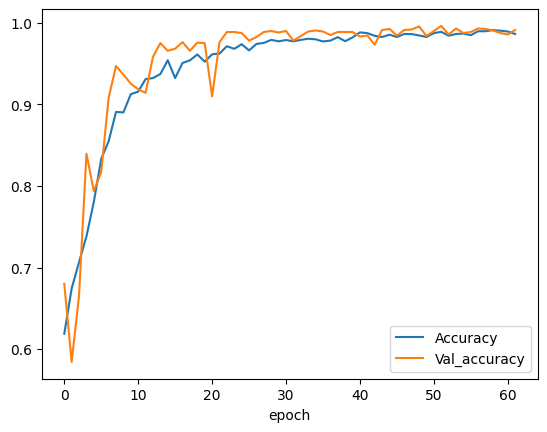

In [53]:
history_df_binary = pd.DataFrame(history_binary.history)

plt.plot(history_df_binary['acc'], label = 'Accuracy')
plt.plot(history_df_binary['val_acc'], label = 'Val_accuracy')
plt.xlabel('epoch')
plt.legend();

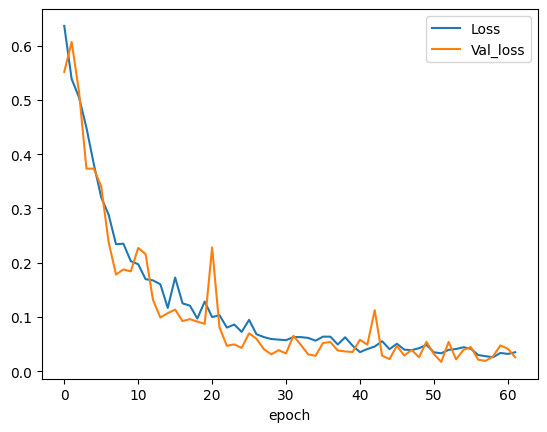

In [54]:
plt.plot(history_df_binary['loss'], label = 'Loss')
plt.plot(history_df_binary['val_loss'], label = 'Val_loss')
plt.xlabel('epoch')

plt.legend();

It can be observed that from epoch 40 onwards, we do not achieve significantly better results for validation accuracy, and the loss function stabilizes for both training and validation

Let's evaluate using the test set

In [130]:
results_test_binary = binary_model.evaluate(X_test, y_test_num_binary)
print(f"Test accuracy: {round(results_test_binary[1]*100,2)}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9992 - loss: 0.0125
Test accuracy: 99.76%


We get the predictions and display the results

In [56]:
predictions_test_binary = binary_model.predict(X_test)
y_pred_num_binary = [1 if prediction > 0.5 else 0 for prediction in predictions_test_binary]
y_pred_label_binary = [inverse_mapping_binary[y] for y in y_pred_num_binary]

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [57]:
print(classification_report(y_test_label_binary, y_pred_label_binary))

              precision    recall  f1-score   support

      defect       1.00      1.00      1.00       629
   no_defect       0.99      0.99      0.99       199

    accuracy                           1.00       828
   macro avg       1.00      1.00      1.00       828
weighted avg       1.00      1.00      1.00       828



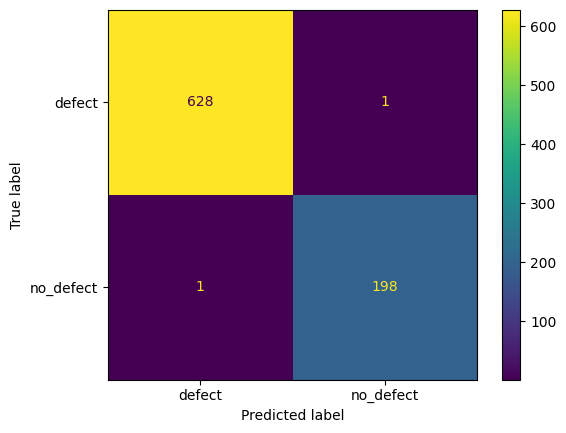

In [58]:
ConfusionMatrixDisplay.from_predictions(y_test_label_binary, y_pred_label_binary);

We are obtaining very good results, and even the errors are balanced

If we display the errors made by the model when evaluating the test set

In [59]:
values = binary_model.predict(X_test).flatten().round(3)

pred_df_binary = pd.DataFrame({"File_name": names, "True": y_test_label_binary, "Predicted": y_pred_label_binary, "Value": values})

incorrect = pred_df_binary["True"] != pred_df_binary["Predicted"]
df_incorrect_binary = pred_df_binary[incorrect]

df_incorrect_binary

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,File_name,True,Predicted,Value
601,IMG_20221108_113543_jpg.rf.b40117c717d472df84d...,defect,no_defect,0.617
642,IMG_20220624_153303_jpg.rf.9fe31465c8f50a373cc...,no_defect,defect,0.001


In [60]:
def plot_image_confidence(images, df):
        
    num_images = len(df.index.tolist())
    
    cols = 4
    if (num_images/cols) % 2 != 0:
        
        rows = num_images//cols + 1
    else:
        
        rows = num_images//cols


    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*4))
    axes = axes.flatten()

    
    for i, index in enumerate(df.index.tolist()):

        axes[i].imshow(images[index]);
        axes[i].set_title(f"True: {df.iloc[i,1]} \n Predicted: {df.iloc[i,2]} \n Value: {df.iloc[i,3].astype(float).round(3)}")
    

    for i in range(rows*cols):
        axes[i].axis("Off")

    plt.tight_layout()
    plt.show()

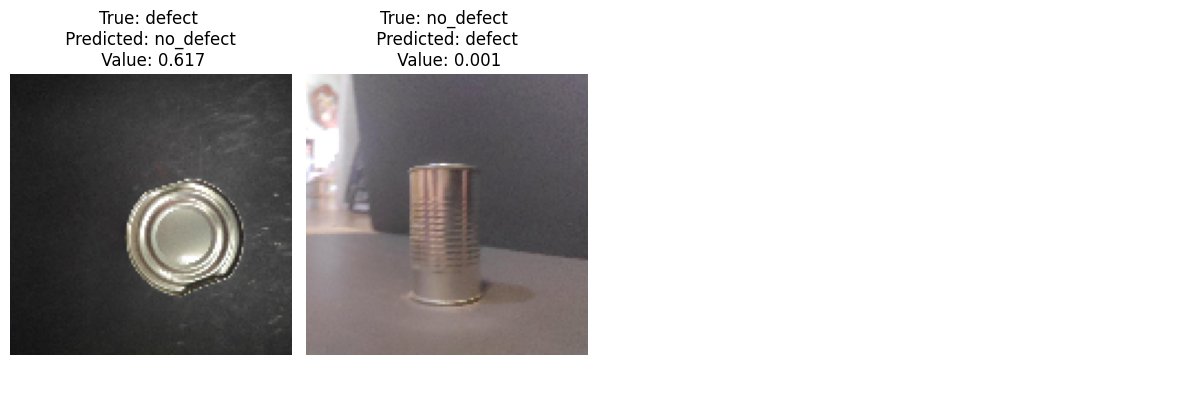

In [61]:
plot_image_confidence(X_test, df = df_incorrect_binary)

Finally, we save the model so that we can use it again and pre-trained

In [62]:
binary_model.save("./models/model_binary/model_binary.keras")

In [63]:
binary_model = keras.models.load_model("./models/model_binary/model_binary.keras")

## 3.2. Multiclass classification 

This time, we are going to do a multiclass classification. We create the model for this purpose

In [89]:
# Create model
multi_model = keras.Sequential()

#First convolutional layer and pooling
multi_model.add(keras.layers.Conv2D(filters = 8, kernel_size = (5, 5), strides = (2,2), input_shape = X_train[0].shape, padding = "same", activation = 'relu'))
multi_model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))

# Dropout layer
multi_model.add(keras.layers.Dropout(0.5))

# Second convolutional layer and pooling
multi_model.add(keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = (2,2), padding = "same", activation = 'relu'))
multi_model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2)))

# Dropout layer
multi_model.add(keras.layers.Dropout(0.5))

# Flatten layer to convert the output from the pooling layer into a vector
multi_model.add(keras.layers.Flatten())

# First hidden dense layer
multi_model.add(keras.layers.Dense(units = 1024, activation = 'relu'))

# Dropout layer
multi_model.add(keras.layers.Dropout(0.5))

# Output layer
multi_model.add(keras.layers.Dense(units = 4, activation='softmax'))

# Compiler
multi_model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


In [90]:
multi_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,055,476 (4.03 MB)

 Trainable params: 1,055,476 (4.03 MB)

 Non-trainable params: 0 (0.00 B)

As previously, we define the early stopping by monitoring validation accuracy

In [91]:
early_stop_multi = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

It is not necessary to calculate the weights for class imbalance because all four classes are balanced, so we train the model

In [92]:
t_zero = time()

history_multi = multi_model.fit(X_train_s, 
                    y_train_num_s,
                    batch_size = batch_size,
                    validation_data = (X_valid, y_valid_num),
                    epochs = 100,
                    callbacks = [early_stop_multi])

time_train_multi = time()-t_zero

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.3266 - loss: 1.3680 - val_accuracy: 0.4935 - val_loss: 1.1761
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4848 - loss: 1.1594 - val_accuracy: 0.4711 - val_loss: 1.1401
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5284 - loss: 1.0582 - val_accuracy: 0.6824 - val_loss: 0.9037
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6148 - loss: 0.9107 - val_accuracy: 0.7365 - val_loss: 0.7400
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6928 - loss: 0.7551 - val_accuracy: 0.7930 - val_loss: 0.5992
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7255 - loss: 0.6626 - val_accuracy: 0.7843 - val_loss: 0.5932
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7500 - loss: 0.6180 - val_accuracy: 0.8403 - val_loss: 0.5008
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7647 - loss: 0.5891 - 

In [93]:
print(f"traning time: {round(time_train_multi // 60)} minutes and {round(time_train_multi % 60)} seconds")

traning time: 2 minutes and 27 seconds


We visualize the training progress

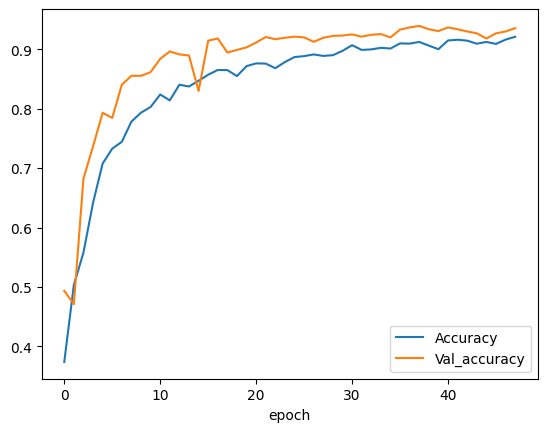

In [94]:
history_df = pd.DataFrame(history_multi.history)

plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')
plt.xlabel('epoch')
plt.legend();

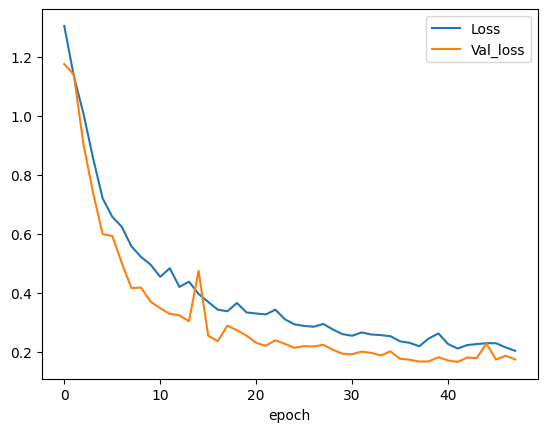

In [95]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')
plt.xlabel('epoch')

plt.legend();

As for binary classification we have very good results and, this time from epoch 20 onwards, we do not achieve significantly better results for validation accuracy, and the loss function stabilizes for both training and validation

Let's evaluate using the test set

In [96]:
results_test_multi = multi_model.evaluate(X_test, y_test_num)
print(f"Test accuracy: {round(results_test_multi[1]*100,2)}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8740 - loss: 0.2821
Test accuracy: 92.75%


In [97]:
y_pred_num = [np.argmax(predictions) for predictions in multi_model.predict(X_test)]
y_pred_label = [inverse_mapping[y] for y in y_pred_num]

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [98]:
print(classification_report(y_test_label, y_pred_label))

                 precision    recall  f1-score   support

critical_defect       0.96      0.89      0.92       202
   major_defect       0.87      0.94      0.90       200
   minor_defect       0.90      0.91      0.90       227
      no_defect       1.00      0.97      0.99       199

       accuracy                           0.93       828
      macro avg       0.93      0.93      0.93       828
   weighted avg       0.93      0.93      0.93       828



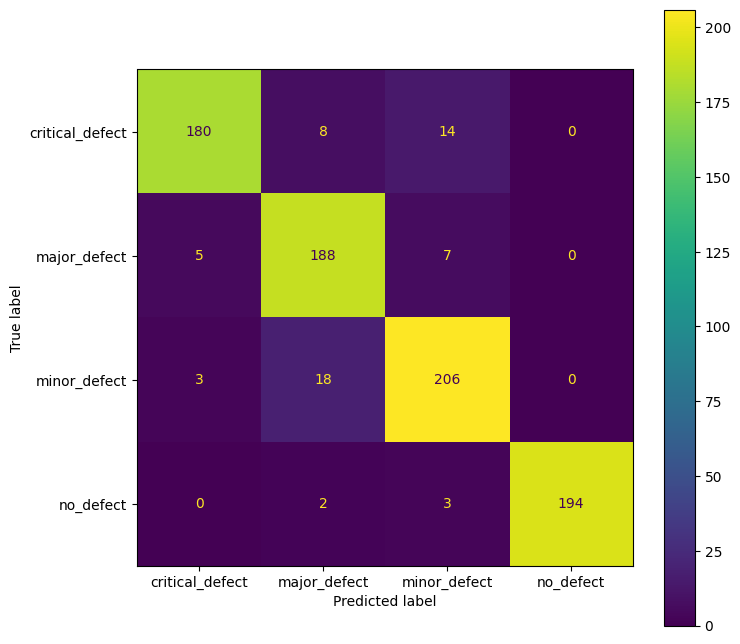

In [99]:
fig,axs = plt.subplots(1,1,figsize = (8,8))
ConfusionMatrixDisplay.from_predictions(y_test_label, y_pred_label, ax=axs);

We found that the model, within the small percentage of error it has, mostly makes mistakes in predicting one class with its contiguous class (except for the class 'critical_defect', where it confuses it more with the class 'minor_defect' than with the class 'major_defect')

Additionally, only in five cases it confuses the class 'no_defect' with a class associated with some defect, in this case 'minor_defect' (3) and 'major_defect' (2)

If we display the errors made by the model when evaluating the test set

In [100]:
confidence = [max(prediction) for prediction in multi_model.predict(X_test)]

pred_df_multi = pd.DataFrame({"File_name": names, "True": y_test_label, "Predicted": y_pred_label, "Confidence": confidence})

incorrect = pred_df_multi["True"] != pred_df_multi["Predicted"]
df_incorrect_multi = pred_df_multi[incorrect]

df_incorrect_multi

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,File_name,True,Predicted,Confidence
1,IMG_20220709_192600_jpg.rf.7451ff1ce7ee88a179b...,critical_defect,major_defect,0.388347
5,IMG_20220709_193606_jpg.rf.147c76cd0be104454c1...,critical_defect,major_defect,0.611804
6,IMG_20220709_193612_jpg.rf.5c52e890fc760ebfea9...,critical_defect,major_defect,0.559288
8,IMG_20220924_192646_jpg.rf.f3594c381c14a7d0725...,critical_defect,minor_defect,0.367219
9,IMG_20220924_193930_jpg.rf.ab12493648681713805...,critical_defect,minor_defect,0.674763
11,IMG_20220924_194108_jpg.rf.f19364623e14ca99ce1...,critical_defect,minor_defect,0.599045
12,IMG_20220924_194145_jpg.rf.e6fc3d7d8e24ebb5c7d...,critical_defect,minor_defect,0.799919
13,IMG_20220924_194923_jpg.rf.f7df04742d62a55147a...,critical_defect,minor_defect,0.684820
15,IMG_20220924_195231_jpg.rf.073c060ae4db7d29a3a...,critical_defect,minor_defect,0.665944
16,IMG_20220924_195243_jpg.rf.e298bfb97c5f005e2b6...,critical_defect,minor_defect,0.610801


In [111]:
def plot_image_confidence(images, labels, predictions, map):

    # Calculamos el número de imágenes
    num_images = len(images)

    # Creamos una cuadrícula de subplots
    rows = num_images
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*7))
    axes = axes.flatten()

    for i in range(num_images):

            # Mostramos la imagen
            axes[2*i].imshow(images[i], cmap='Greys');
            
            # Colocamos el título con el valor de la etiqueta
            label_pred = np.argmax(predictions[i])
            axes[2*i].set_title(f"True: {map.get(labels[i])} \n Predicted: {map.get(label_pred)} (Confidence: {round(predictions[i].max()*100,2)}%)")

            
            # Quitamos los números de los ejes
            axes[2*i].set_yticklabels([])
            axes[2*i].set_xticklabels([])
            
            # Mostramos el grafico con las confianzas calculadas por el modelo
            axes[(2*i)+1].bar(map.values(), predictions[i])
            
            # Mostramos el título
            axes[(2*i)+1].set_title("Confidence")

    plt.tight_layout()
    plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


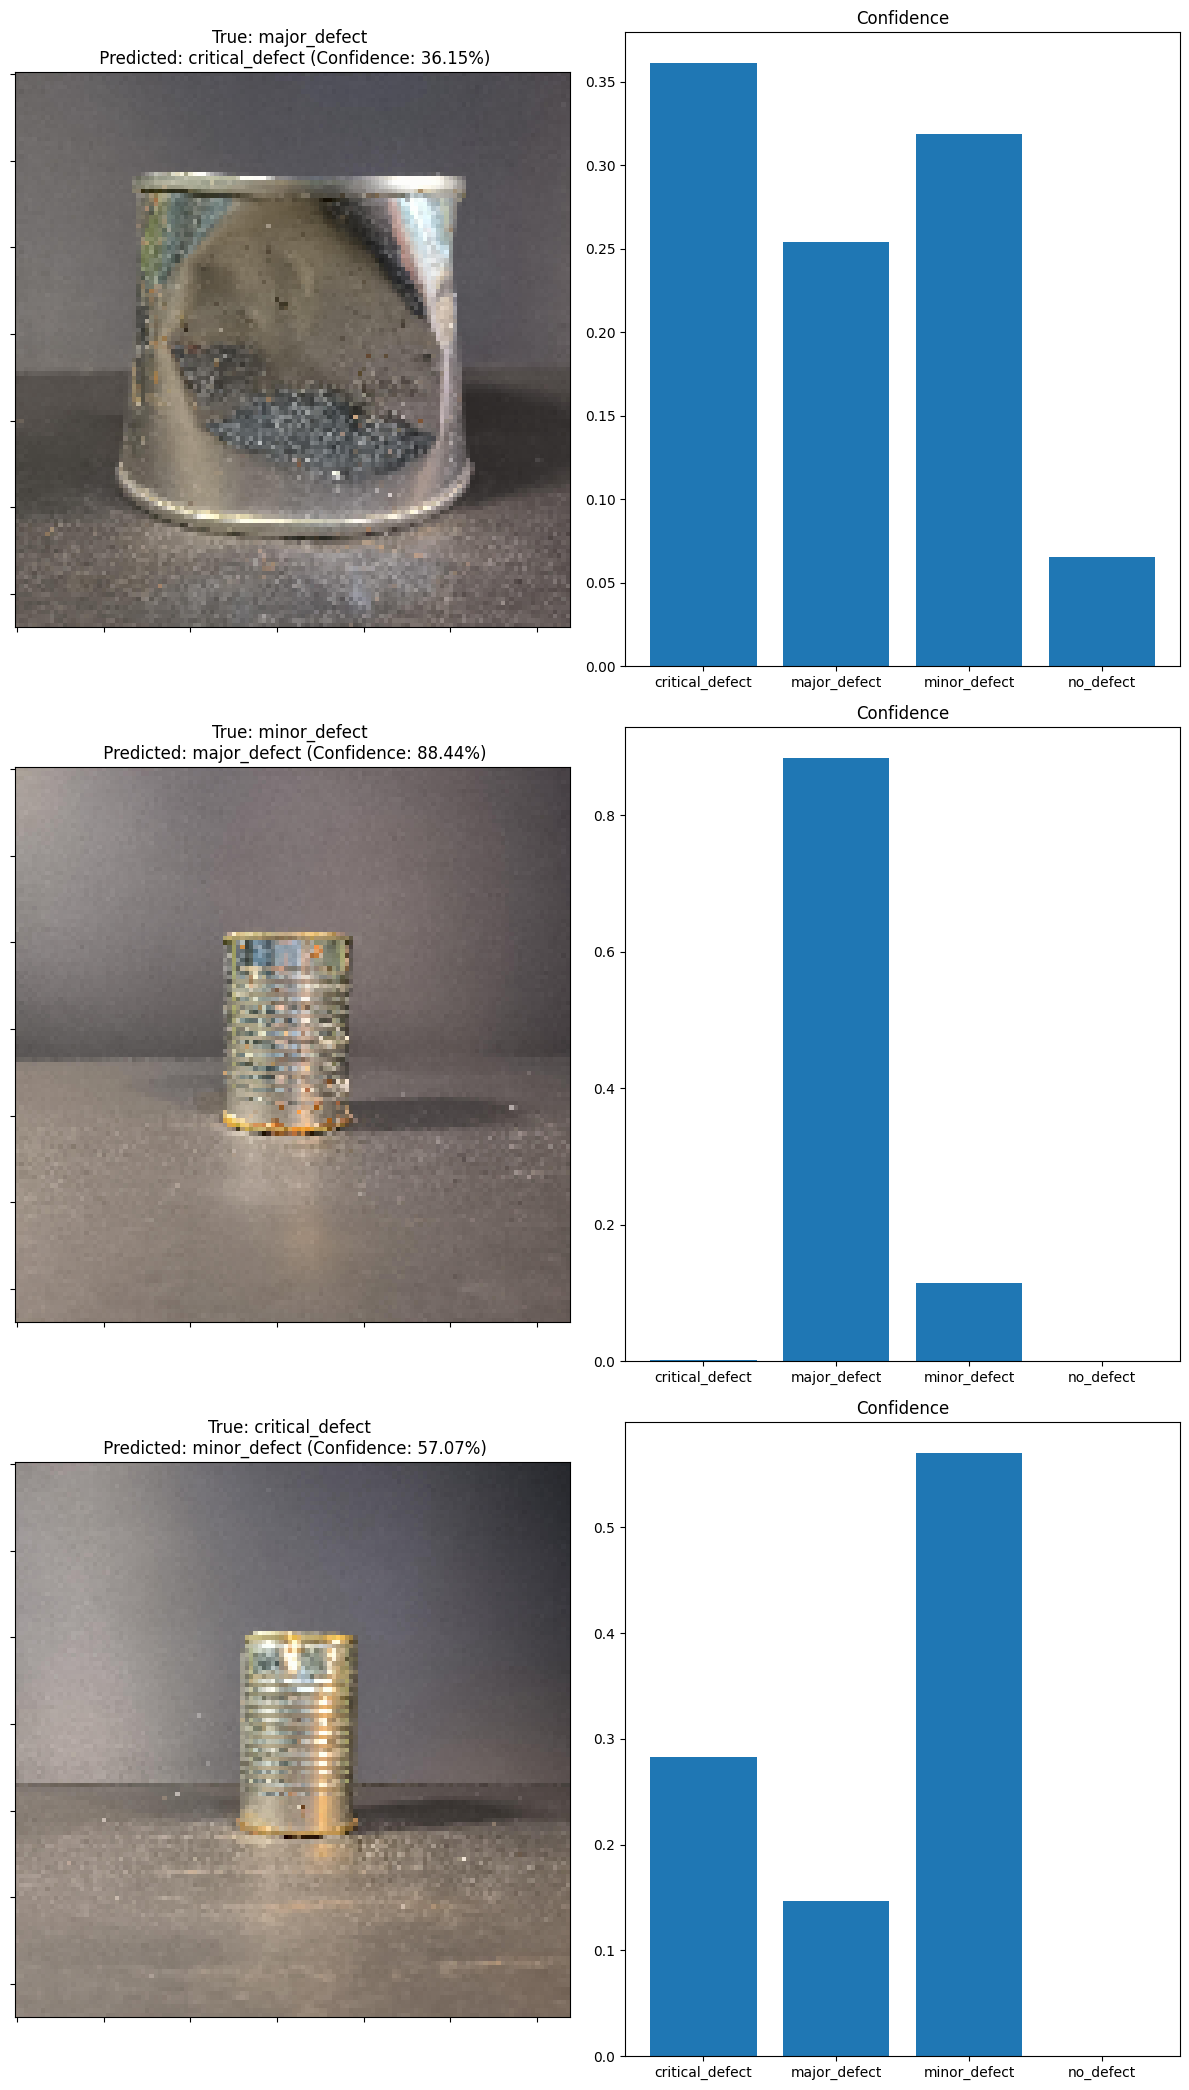

In [123]:
predictions = multi_model.predict(X_test)
index = random.sample(df_incorrect_multi.index.to_list(), 3) #Show only 3 mistakes

plot_image_confidence(X_test[index], y_test_num[index], predictions[index], map=inverse_mapping)

Finally, we save the model so that we can use it again and pre-trained

In [106]:
multi_model.save("./models/model_multi/model_multi.keras")

In [107]:
multi_model = keras.models.load_model("./models/model_multi/model_multi.keras")

# 4. Conclusions

The results of the modeling process has been very good, despite reducing the resolution of the images to 128 x 128 pixels. When evaluating against the test set, we achieve a 99.8% *accuracy* in binary classification and 92.8% *accuracy* in multiclass classification. These good results are largely due to the images being captured under suitable background and lighting conditions, which helped to eliminate visual noise. This allowed the model to correctly identify the cans and their associated classes.


These results support the implementation of such models in production lines or inspection processes. Under suitable conditions for automated image collection, they could significantly reduce the need for physical inspection (or reinspection) of all products in intermediate processes by an operator. A combined strategy that combines machine learning model-based inspection for less critical processes with human inspection for more critical processes would contribute significantly to cost savings (making the product more competitive) and also prevent quality escapes that negatively impact the product's image.